In [ ]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-2e836b6f-f817-4653-9b5b-c37672355d7f',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'l5uqYvUJYCH-NadiaqwbWyPqmqX5C4b4xE8Xlf3pAa54'
}

configuration_name = 'os_e010c136b1e444bca9d7a49415948494_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-pbj8lr99p2t68k'))
df.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190208202104-0000
KERNEL_ID = 10feea73-00e0-47dc-b388-f08897428adc


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, avg, desc,countDistinct, count, concat, lit, when
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier,LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import IntegerType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Explore and Clean Dataset

In [ ]:
df.printSchema()

In [12]:
# Number of records in the dataframe
n_records = df.count()
print('the number of records in the dataset {}'.format(n_records))

the number of records in the dataset 528005


In [13]:
# print the summary of all the columns in the dataframe.
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,432877,527.5289537712895,966.1072451772758,!!!,ÃÂlafur Arnalds
auth,528005,None,None,Cancelled,Logged In
firstName,528005,None,None,Aaliyah,Zyonna
gender,528005,None,None,F,M
itemInSession,528005,107.77899451709737,116.8647866296988,0,1005
lastName,528005,None,None,Abbott,Wright
length,432877,248.66459278007738,98.41266955051972,0.78322,3024.66567
level,528005,None,None,free,paid
location,528005,None,None,"Akron, OH","York-Hanover, PA"


In [14]:
# We have established that 'auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts', 'userId' 
# have no missing values, but what about empty strings. Lets find out.
col_lst_no_missing_val = \
        ['auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts', 'userId']

for col_name in col_lst_no_missing_val:
    cnt = df.filter(col(col_name) == '').count()
    if cnt>0:
        print('the column '+str(col_name)+' has {} missing values'.format(cnt))

**Looks like we have 8346 empty strings in 'userId' column.**

In [15]:
# drop all rows that have atleast one missing value. 
df_no_na = df.na.drop(how = 'any')
n_records_no_na = df_no_na.count()

print('the number of records without any missing values {}'\
                                              .format(n_records_no_na))

the number of records without any missing values 432877


In [16]:
# create a dataframe out of records that have atleast one missing value
df_atleast_one_na = df.subtract(df_no_na)
n_records_atleast_one_na = df_atleast_one_na.count()

print('the number of rows with atleast one missing value {}'\
                                              .format(n_records_atleast_one_na))

the number of rows with atleast one missing value 95128


In [17]:
# print the summary of the dataframe df_atleast_one_na
df_atleast_one_na.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,0,None,None,None,None
auth,95128,None,None,Cancelled,Logged In
firstName,95128,None,None,Aaliyah,Zyonna
gender,95128,None,None,F,M
itemInSession,95128,99.28275586578084,111.84054426305747,0,994
lastName,95128,None,None,Abbott,Wright
length,0,None,None,None,None
level,95128,None,None,free,paid
location,95128,None,None,"Akron, OH","York-Hanover, PA"


**Looking at the above summary, we can make few deductions. Whenever the 'artist' column has a value, all the other columns have a value too- same goes for 'length' and 'song' columns. We have already identified that the columns 'auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts', have no missing values. When we look at the remaining columns 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent', their missing values seem to follow a pattern. They are missing 58392 - 50046 = 8346 values each. Also, you might recall the column 'userId' had the same number(8346) of empty strings. Moreover, all this missing 8346 values in various columns could be occuring simultaneously. Lets find out why that is the case. To summarise, 58392 records don't have value for 'artist', 'length' and 'song' column, and in this 58392 records 8346 has no values for the following columns 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent', 'userId'.**

In [20]:
# The unique values in each of the four columns listed above from the original dataframe:
for col_name in ['auth', 'level', 'method', 'page']:
    lst = df.select(col(col_name))\
                        .filter((col(col_name).isNotNull()) & (col(col_name) != ''))\
                        .dropDuplicates().collect()
    if len(lst) > 0:
        print('the column name "'+str(col_name)\
                +'" has following unique values in the dataframe where there is atleast 1 missing value in each row')
        for lst_val in lst:
            print(lst_val[0])
        print("\n")

the column name "auth" has following unique values in the dataframe where there is atleast 1 missing value in each row
Cancelled
Logged In


the column name "level" has following unique values in the dataframe where there is atleast 1 missing value in each row
free
paid


the column name "method" has following unique values in the dataframe where there is atleast 1 missing value in each row
PUT
GET


the column name "page" has following unique values in the dataframe where there is atleast 1 missing value in each row
Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Settings
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade




In [21]:
# The unique values in each of the four columns listed above from the dataframe that has no missing values in any of its 
# records:
for col_name in ['auth', 'level', 'method', 'page']:
    lst = df_no_na.select(col(col_name))\
                        .filter((col(col_name).isNotNull()) & (col(col_name) != ''))\
                        .dropDuplicates().collect()
    if len(lst) > 0:
        print('the column name "'+str(col_name)\
                +'" has following unique values in the dataframe where there is atleast 1 missing value in each row')
        for lst_val in lst:
            print(lst_val[0])
        print("\n")

the column name "auth" has following unique values in the dataframe where there is atleast 1 missing value in each row
Logged In


the column name "level" has following unique values in the dataframe where there is atleast 1 missing value in each row
free
paid


the column name "method" has following unique values in the dataframe where there is atleast 1 missing value in each row
PUT


the column name "page" has following unique values in the dataframe where there is atleast 1 missing value in each row
NextSong




In [22]:
# The unique values in each of the columns when the dataframe has atleast one missing value in all its records.
for col_name in ['auth', 'level', 'method', 'page']:
    lst = df_atleast_one_na.select(col(col_name))\
                                .filter((col(col_name).isNotNull()) & (col(col_name) != ''))\
                                .dropDuplicates().collect()
    if len(lst) > 0:
        print('the column name "'+str(col_name)\
                +'" has following unique values in the dataframe where there is atleast 1 missing value in each row')
        for lst_val in lst:
            print(lst_val[0])
        print("\n")

the column name "auth" has following unique values in the dataframe where there is atleast 1 missing value in each row
Cancelled
Logged In


the column name "level" has following unique values in the dataframe where there is atleast 1 missing value in each row
free
paid


the column name "method" has following unique values in the dataframe where there is atleast 1 missing value in each row
PUT
GET


the column name "page" has following unique values in the dataframe where there is atleast 1 missing value in each row
Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Settings
Add to Playlist
Add Friend
Thumbs Up
Help
Upgrade
Error
Submit Upgrade




**When you look at the last 3 cells and examine its results, it is clear that when the user is logged in and he is playing a song(NextSong) there is no missing values on any columns for that record. However, when the user is not playing a song, understandably, we don't have values for the following columns 'artist', 'song' and 'length' for that record. Furthermore, when the user logs out or he is registered as Guest user we don't have values for the following additional columns -  'firstName','gender', 'lastName', 'location', 'registration', 'userAgent', 'userId' along with the three columns mentioned above.**

**When you look at 'page' column in the above 3 cells, we can say the following things. The user can access the following pages of the websites whether he is logged in or logged out or as a Guest user. 1)Home 2)About 3)Submit Registration 4)Login 5)Register 6)Help 7)Error. Also, it is clear that the user cannot access the following pages of the website if he is not logged in 1)Cancel 2)Submit Downgrade 3)Thumbs Down 4)Downgrade 5)Roll Advert 6)Logout 7)Save Settings 8)Cancellation Confirmation 9)Settings 10)Add to Playlist 11)Add Friend 12)NextSong 13)Thumbs Up 14)Upgrade 15)Submit Upgrade.**

In [95]:
# Perhaps it is best to remove both 'Logged Out' and 'Guest' values in 'auth' column as we are tring to predict if the users 
# will churn or not. Both 'Logged Out' and 'Guest' have userIds missing.
df = df.filter((df.auth != 'Guest') & (df.auth != 'Logged Out'))
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



# Exploratory Data Analysis

### Define Churn

Anyone who visited the page 'Cancellation Confirmation' has cancelled their subscription with Sparkify. We can say these customers have churned.

In [96]:
# find userids for all the users who churned
churned_user_ids = df.filter(df.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()

In [97]:
df = df.withColumn('churn', when(col("userId").isin(churned_user_ids), 1).otherwise(0))

In [26]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
artist,Martin Orford,John Brown's Body,Afroman,None,Lily Allen
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Joseph,Sawyer,Maverick,Maverick,Gianna
gender,M,M,M,M,F
itemInSession,20,74,184,185,22
lastName,Morales,Larson,Santiago,Santiago,Campos
length,597.551,380.212,202.37,NaN,194.533
level,free,free,paid,paid,paid
location,"Corpus Christi, TX","Houston-The Woodlands-Sugar Land, TX","Orlando-Kissimmee-Sanford, FL","Orlando-Kissimmee-Sanford, FL","Mobile, AL"
method,PUT,PUT,PUT,PUT,PUT


In [27]:
# Looks like 'Cancelled' in 'auth' column also represents churn. Lets find out churn ratio just for fun.

# Dataframe method
# df.filter((col('userId').isNotNull()) & (col('userId') != ''))\
#                         .groupby('auth').agg(countDistinct('userId')\
#                         .alias('unique_user_count')).show()

df.createOrReplaceTempView('df_table')

# SQL method
df_auth = spark.sql("SELECT auth, COUNT(DISTINCT userId) as unique_user_count\
                     FROM df_table\
                     WHERE userId IS NOT NULL AND userID != ''\
                     GROUP BY auth\
                     ORDER BY unique_user_count DESC")

df_auth.show()

n_users_registered = df_auth.filter(col('auth') == 'Logged In')\
                             .select('unique_user_count').first()[0]
n_users_left = df_auth.filter(col('auth') == 'Cancelled')\
                             .select('unique_user_count').first()[0]

print('The number of users registered: {} and the number of users left: {} with a churn ratio of: {}'\
                             .format(n_users_registered,n_users_left,round((n_users_left/n_users_registered),2)))

+---------+-----------------+
|     auth|unique_user_count|
+---------+-----------------+
|Logged In|              448|
|Cancelled|               99|
+---------+-----------------+

The number of users registered: 448 and the number of users left: 99 with a churn ratio of: 0.22


## Explore Data

In [28]:
# Let's find the average number of songs played by churned and unchurned user.
df_songs_count = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .count()

df_songs_unique_users = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .agg(countDistinct(col('userId')))

avg_num_songs_played = df_songs_unique_users\
                .join(df_songs_count, df_songs_count.churn == df_songs_unique_users.churn)\
                .drop(df_songs_count.churn)

avg_num_songs_played = avg_num_songs_played\
                .withColumn('AvgNumberofSongs', \
                avg_num_songs_played['count']/avg_num_songs_played['count(DISTINCT userId)'])

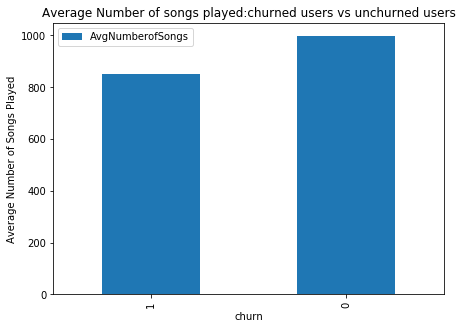

In [29]:
# plotting average number of songs played for churned and unchurned users
df_plt = avg_num_songs_played.select(['churn', 'AvgNumberofSongs']).toPandas().set_index('churn')
df_plt.plot(kind = 'bar', figsize = (7, 5), title = 'Average Number of songs played:churned users vs unchurned users');
plt.ylabel('Average Number of Songs Played');

In [30]:
# Average number of times each page is vistied: churned vs unchurned users.
df_page_churn_count = df.groupby(['churn','page']).agg({'page':'count'})

avg_num_page_visit = df_page_churn_count\
                .join(df_songs_unique_users, df_songs_unique_users.churn == df_page_churn_count.churn)\
                .drop(df_songs_unique_users.churn)

avg_num_page_visit = avg_num_page_visit\
                .withColumn('AvgNumberofPageVisit', avg_num_page_visit['count(page)']/avg_num_page_visit['count(DISTINCT userId)'])

In [31]:
# I am leaving out "NextSong" page as it dominates every other page, moreover NextSong has been shown seperately in the plot
# above.
avg_num_page_visit = avg_num_page_visit.filter(col('page') != 'NextSong')
avg_num_page_visit = avg_num_page_visit.toPandas()

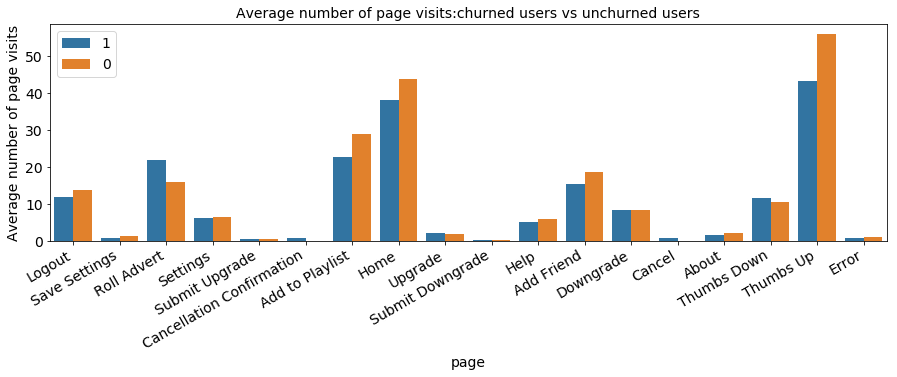

In [179]:
# Plotting average number of times each page is vistied: churned vs unchurned users.
fig = plt.figure(figsize=(15, 4))
sns.barplot(x="page",y="AvgNumberofPageVisit", hue="churn", data=avg_num_page_visit, hue_order=[1, 0]);
plt.xticks(rotation=90, fontsize=14);
plt.yticks(fontsize=14)
plt.xlabel("page", fontsize=14)
plt.ylabel("Average number of page visits", fontsize=14)
plt.title("Average number of page visits:churned users vs unchurned users", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

In [98]:
# create user defined functions to get hour, date and timestamp from the unix_timestamp format given in the dataframe
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())

get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0)\
                                                           .strftime("%Y-%m-%d"))
get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0)\
                                                           .strftime("%Y-%m-%d %H:%M:%S"))

In [99]:
# create columns of hour, date and timestamp 
df = df.withColumn('ts_hour', get_hour('ts'))
df = df.withColumn('ts_date', get_date('ts'))
df = df.withColumn('ts_timestamp', get_timestamp('ts'))

In [100]:
# plot user churn ratio per hour
df_plt = df.filter(col('page')=='Cancellation Confirmation')\
                                            .groupby(col('ts_hour')).count().orderBy('ts_hour')
df_plt.createOrReplaceTempView('df_plt_table')

df_plt = spark.sql("SELECT *, ROUND(COUNT/SUM(COUNT) OVER(),2) AS churn_ratio\
                    FROM df_plt_table")

df_plt_pd = df_plt.toPandas()

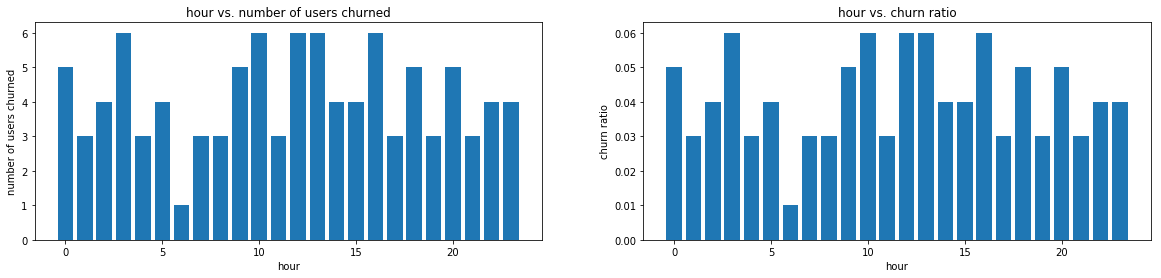

In [101]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(20, 4));
ax1.bar(df_plt_pd['ts_hour'], df_plt_pd['count']);
ax1.set_xlabel('hour');
ax1.set_ylabel('number of users churned');
ax1.set_title('hour vs. number of users churned');
ax2.bar(df_plt_pd['ts_hour'], df_plt_pd['churn_ratio']);
ax2.set_xlabel('hour');
ax2.set_ylabel('churn ratio');
ax2.set_title('hour vs. churn ratio');

# Feature Engineering

When we are building a model with structured data just as we are doing now, the efficiency of our model will depend very heavily on features that we engineer or identify. If we could identify those features that correlate strongly with the target variable, any machine learning model we build will have a very high accuracy. Also, we should be on guard to not add features that have near zero correlation with the target variable. They not only add noise to our data but also muddles our model.

Towards that end, lets think aloud on what makes the customer to leave a service. I have a sneaking suspicion that any non-essential service will lose customers because of two major set of reasons.

    1) Flaws or gaps in the service leading to customer dissatisfaction.
    2) The customer has a predisposition.
Let me expand a little bit on what i mean by customer predisposition - This type of customers will leave even if the service is perfect and meets or exceeds their expectations. One of the reason could be time consciousness(they don't want to spend a lot of time listening to music and they believe their time is being wasted because of this music service and they quit).

The reason i am bringing this up is because users who have identified a gap in the service or having a predisposition, their interaction with the website before and after they became a paid member would have been different with the rest of the users. Maybe, they lingered longer as a free member before deciding to give paid membership a shot when compared to other users. Alternatively, they visited different set of pages with different frequency when compared to other users. Whatever it is there must be a pattern emerging indicating indecisiveness or disillusionment.

If we scrutnized the data for these 2 class of users(churned and unchurned) before and after they became a paid member, I guess we have a very good shot at building a pretty good machine learning model. Ofcourse, these are all my suspicions and lets find out if my suspicion holds water.

In [102]:
# Lets concat the columns level and page. This way we can easily sepearate the activities before and after the user 
# becomes a paid member(if at all he becomes one). I am doing this to confirm my above mentioned suspicion.
df = df.withColumn('level_page', concat(col("level"), lit('_'), col("page")))

# Now lets pivot on the newly created column 'level_page'
df_pivot = df.groupby(["userId"])\
                        .pivot("level_page")\
                        .count()\
                        .fillna(0)

In [103]:
# Now lets add 'free_Submit Registration' and 'paid_Cancellation Confirmation' into a single target variable 'churn'
df_pivot.createOrReplaceTempView('df_pivot_table')

df_pivot = spark.sql("SELECT *, (`paid_Cancellation Confirmation` + `free_Cancellation Confirmation`) AS churn\
                      FROM df_pivot_table")

In [104]:
# And drop the two original columns as well as UserId in preparation for creating Independent and target variables for the model.
# I am removing 'paid_cancel' and 'free_cancel' as every single user that clicks cancel has also churned out.By the time they
# clicked visit cancel page it is already too late. 
df_pivot = df_pivot.drop('free_Cancellation Confirmation', 'paid_Cancellation Confirmation','paid_Cancel', 'free_Cancel')

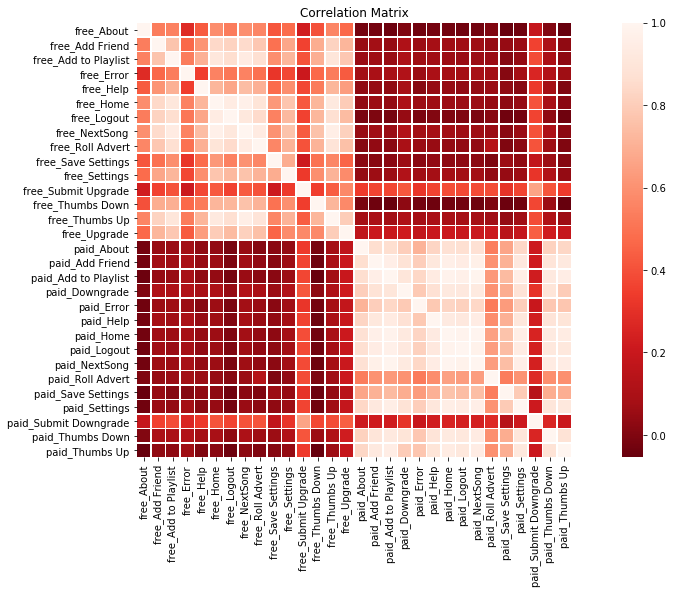

In [105]:
# heatmap to understand the correlation between variables in the independent variables
independent_var = df_pivot.columns
independent_var.remove('churn')

# target variable is renamed as label
df_pivot = df_pivot.withColumnRenamed('churn', 'label')

fig = plt.figure(figsize=(18,8))
ax = plt.gca()
ax.set_title("Correlation Matrix")
sns.heatmap(df_pivot.toPandas()[independent_var].corr(), annot = False, \
                                    linewidths=0.5, square = True, cmap = 'Reds_r');

In [106]:
# Lets remove columns that have correlation that is close to 1. To put it in other words, If two columns have a correlation of 
# close to 1, one of the columns should be deleted as our model stands to gain precious little by keeping both the columns.
# I am dropping one of the columns when two columns have correlartion of 0.95 or more.
df_pivot = df_pivot.drop('free_NextSong', 'paid_Home', 'paid_Logout', 'paid_Add to Playlist')

In [107]:
df.createOrReplaceTempView('df_table')

In [108]:
# Number of days as a free user
df_n_days_free_user = spark.sql("SELECT userId, DATEDIFF(MAX(ts_date), MIN(ts_date)) AS n_days_free_user\
                                FROM df_table\
                                WHERE level = 'free'\
                                GROUP BY userId")

In [109]:
# Number of sessions as a free user
df_n_sessions_free_user = spark.sql("SELECT userId, COUNT(DISTINCT sessionId) AS n_sessions_free_user\
                                    FROM df_table\
                                    WHERE level = 'free'\
                                    GROUP BY userId")

In [110]:
# Average time spent in a session
df_avg_time_per_session = spark.sql("SELECT T.userId, SUM(n_hrs_in_session)/COUNT(sessionId) AS avg_time_per_session\
                                    FROM (SELECT userId, sessionId,\
                                        ROUND(((UNIX_TIMESTAMP(MAX(ts_timestamp)) - UNIX_TIMESTAMP(MIN(ts_timestamp)))/(60*60)),2) AS n_hrs_in_session\
                                    FROM df_table\
                                    GROUP BY userId, sessionId\
                                    ORDER BY userId ASC) AS T\
                                    GROUP BY T.userId\
                                    ORDER BY T.userId")

In [111]:
# Average number of songs played per session
df_avg_n_songs_per_session = spark.sql("SELECT userId, (COUNT(song)/COUNT(DISTINCT sessionId)) AS avg_n_songs_per_session\
                                        FROM df_table\
                                        GROUP BY userId")

In [112]:
# creating a temp view
df_pivot.createOrReplaceTempView('df_pivot_table')

df_n_days_free_user\
            .createOrReplaceTempView('df_n_days_free_user_table')

df_n_sessions_free_user\
            .createOrReplaceTempView('df_n_sessions_free_user_table')

df_avg_time_per_session\
            .createOrReplaceTempView('df_avg_time_per_session_table')

df_avg_n_songs_per_session\
            .createOrReplaceTempView('df_avg_n_songs_per_session_table')

In [113]:
# joining all the features with the main dataframe df_pivot
df_pivot = spark.sql("SELECT T1.*, T2.avg_n_songs_per_session\
                    FROM (SELECT T1.*, T2.avg_time_per_session\
                    FROM (SELECT T1.*, T2.n_sessions_free_user\
                    FROM (SELECT T1.*, T2.n_days_free_user\
                    FROM df_pivot_table AS T1\
                    LEFT OUTER JOIN df_n_days_free_user_table AS T2\
                    ON T1.userId = T2.userId) AS T1\
                    LEFT OUTER JOIN df_n_sessions_free_user_table AS T2\
                    ON T1.userId = T2.userId) AS T1\
                    LEFT OUTER JOIN df_avg_time_per_session_table AS T2\
                    ON T1.userId = T2.userId) AS T1\
                    LEFT OUTER JOIN df_avg_n_songs_per_session_table AS T2 \
                    ON T1.userId = T2.userId")

In [114]:
# filling all the missing values with 0.
df_pivot = df_pivot.na.fill(0)
pd.DataFrame(df_pivot.take(10), columns=df_pivot.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
userId,100010,200002,296,125,124,51,7,200037,169,205
free_About,0,1,0,0,0,0,2,1,0,0
free_Add Friend,3,2,2,3,0,0,16,2,6,0
free_Add to Playlist,1,4,2,2,0,0,6,4,0,0
free_Error,0,0,0,0,0,0,0,0,0,0
free_Help,0,1,1,2,0,0,3,0,0,0
free_Home,3,12,4,2,0,0,36,6,6,0
free_Logout,1,6,2,0,0,0,11,0,0,0
free_Roll Advert,22,11,9,6,0,0,35,9,13,0
free_Save Settings,0,0,0,0,0,0,2,0,1,0


# Modeling

In [115]:
# create a list of all the independent variables
ind_var = df_pivot.drop('label', 'userId').columns

In [116]:
def model_performance_metrics(model, data, evaluation_metric):
    '''
    This function receives a ml model, the data that needs to be predicted and the evaluation metric, and
    then return the score and confusion matrix for the model.   
    
    :param model: ml model
    :param data: test data
    :param evaluation_metric: Parameter to evaluate the model with 
    :return:  the score and confusion matrix for the model
    '''
    scorer = MulticlassClassificationEvaluator(metricName = evaluation_metric)
    preds = model.transform(data)
    
    score = scorer.evaluate(preds)
    confusion_matrix = (preds.groupby("label").pivot("prediction").count().toPandas())      
    
    return score, confusion_matrix 

In [127]:
#splitting the data
df_training, df_test = df_pivot\
                                .randomSplit([0.8, 0.2])

# instantiating vectorassembler and minmaxscaler for creating a pipeline
assembler = VectorAssembler(inputCols = ind_var,\
                                outputCol = "Features")

scaler = MinMaxScaler(inputCol = 'Features',\
                              outputCol ='ScaledFeatures')

In [128]:
# instantiating logistic regression model
lr = LogisticRegression(featuresCol="ScaledFeatures", 
                        labelCol="label", 
                        maxIter=10, regParam=0.01)

# creating pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# building paramgrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5]) \
    .addGrid(lr.maxIter,[5, 10, 15])\
    .addGrid(lr.regParam,[0.0]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,\
                             estimatorParamMaps=paramGrid,\
                             evaluator=MulticlassClassificationEvaluator(),\
                             numFolds=3)

cvModel_lr = crossval_lr.fit(df_training)
results = cvModel_lr.transform(df_test)

In [129]:
# Find out which model scored the highest for our evaluation metric
cvModel_lr.avgMetrics

[0.7533696092705228,
 0.7811872632657475,
 0.7793170009598217,
 0.7533696092705228,
 0.7811872632657475,
 0.7793170009598217,
 0.7533696092705228,
 0.7811872632657475,
 0.7793170009598217]

In [130]:
score_lr, confusion_matrix_lr = model_performance_metrics(cvModel_lr, df_test, 'f1')
print('the score for logistic regression model: {}'.format(score_lr))
confusion_matrix_lr

the score for logistic regression model: 0.8443411881845336


,label,0.0,1.0
0,0,60,3
1,1,8,6


In [131]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print('precision: {} recall: {} f1-score: {}'.format(precision, recall, f1))

precision: 0.6666666666666666 recall: 0.42857142857142855 f1-score: 0.5217391304347826


In [132]:
# instantiating random forests model
rf = RandomForestClassifier(labelCol="label",\
                            featuresCol="ScaledFeatures",\
                            featureSubsetStrategy='sqrt')

# creating pipeline
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])

# building paramgrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .addGrid(rf.numTrees,[10, 25, 50, 100]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,\
                             estimatorParamMaps=paramGrid,\
                             evaluator=MulticlassClassificationEvaluator(),\
                             numFolds=3)

cvModel_rf = crossval_rf.fit(df_training)
results = cvModel_rf.transform(df_test)

In [133]:
# Find out which model scored the highest for our evaluation metric
cvModel_rf.avgMetrics

[0.6767402883352018,
 0.7311931441723979,
 0.749562725431462,
 0.7540959918212832,
 0.6724418687200251,
 0.7082503600727647,
 0.7621726689514328,
 0.7529307431893596,
 0.6724418687200251,
 0.6966399882337271,
 0.7498671016121454,
 0.7576834769637624,
 0.6724418687200251,
 0.708224040363058,
 0.7382533091745034,
 0.7512903337724421,
 0.6767402883352018,
 0.7381618232283884,
 0.7459093623137891,
 0.7539588929515102,
 0.6724418687200251,
 0.7132543303018297,
 0.7708119437993657,
 0.7622966170647654,
 0.6724418687200251,
 0.7198344122020957,
 0.7727326052578272,
 0.7569789844823859,
 0.6724418687200251,
 0.687082932954253,
 0.7350341898798973,
 0.7563468140445843]

In [134]:
score_rf, confusion_matrix_rf = model_performance_metrics(cvModel_rf, df_test, 'f1')
print('the score for random forest model: {}'.format(score_rf))
confusion_matrix_rf

the score for random forest model: 0.8388294711824124


,label,0.0,1.0
0,0,63,NaN
1,1,10,4.0


In [135]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print('precision: {} recall: {} f1-score: {}'.format(precision, recall, f1))

precision: 1.0 recall: 0.2857142857142857 f1-score: 0.4444444444444445


In [73]:
# instantiating Gradient Boosted Trees Classifier
gbt = GBTClassifier(labelCol="label",\
                    featuresCol="ScaledFeatures")

# creating pipeline
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

# building paramgrid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[5, 10, 20]) \
    .addGrid(gbt.maxDepth,[3, 6, 9]) \
    .build()

crossval_gbt = CrossValidator(estimator=pipeline_gbt,\
                              estimatorParamMaps=paramGrid,\
                              evaluator=MulticlassClassificationEvaluator(),\
                              numFolds=3)

cvModel_gbt = crossval_gbt.fit(df_training)
results = cvModel_gbt.transform(df_test)

In [74]:
# Find out which model scored the highest for our evaluation metric
cvModel_gbt.avgMetrics

[0.7724084640990552,
 0.727915573714604,
 0.7230458730329483,
 0.786157198436413,
 0.727915573714604,
 0.7230458730329483,
 0.7802835738481855,
 0.7306548963404834,
 0.7209734451855023]

In [75]:
score_gbt, confusion_matrix_gbt = model_performance_metrics(cvModel_gbt, df_test, 'f1')
print('the score for gbt model: {}'.format(score_gbt))
confusion_matrix_gbt

the score for gbt model: 0.7713109121306297


,label,0.0,1.0
0,0,69,6
1,1,13,4


In [76]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print('precision: {} recall: {} f1-score: {}'.format(precision, recall, f1))

precision: 0.4 recall: 0.23529411764705882 f1-score: 0.29629629629629634


**Logistic Regression gives the most balanced model for our dataset with a score of 0.84. The precision, recall and f1-score obtained by this model are 0.66, 0.4285, and 0.5217 respectively. Even though the metrics are not all that stellar, the unbalanced nature of the dataset, as only 18% of the users churned, is the culprit. By undersampling or over sampling we would get better evaluation metric.**

# Feature Importance

Lets pick the best model(logisitic regression) we identified above and closely examine the features that contribute to churn. Features with positive correlation contributes to churn and vice versa with the features that have negative correlation.

In [177]:
feature_coef_df = pd.DataFrame(list(zip(ind_var, list(cvModel_lr.bestModel.stages[-1].coefficients))), columns=['Feature', 'Coefficient'])\
                            .sort_values('Coefficient', ascending=False)

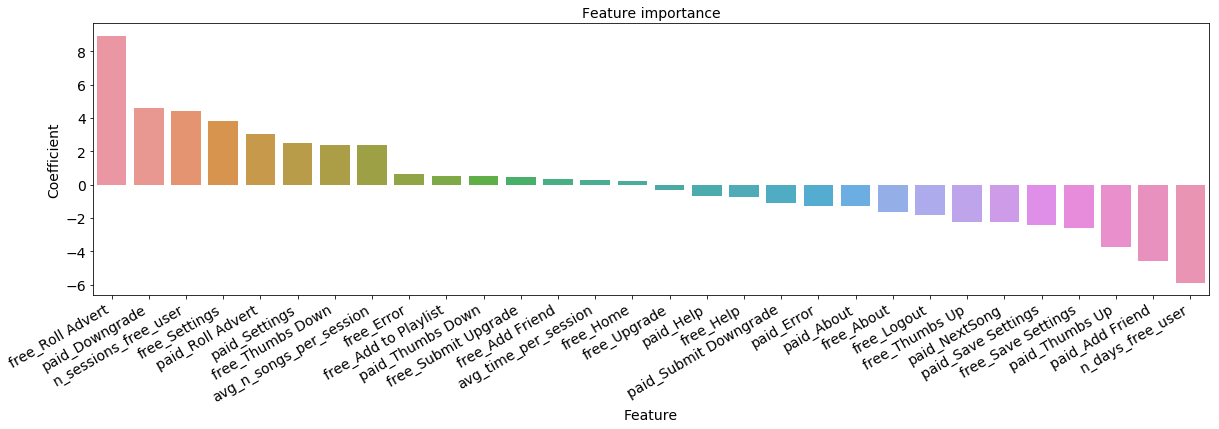

In [178]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

**Understandably, free_Roll_Advert(advertisement while the customer is a free user) contributes the most to churn. Paid_Roll_Advert is not far behind, It is fifth biggest contributor to churn. On the other end of the spectrum, n_days_free_user(number of days as a free user) contributes most to the retention of the customer.**